#### Torch CNN - CIFAR10

In [1]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import os, sys
from pathlib import Path
sys.path.append(str(Path('.ipynb').resolve().parents[2]))

BATCH_SIZE = 128
DOWNLOAD = False
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='/home/tung5534/cnn_cifar/data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='/home/tung5534/cnn_cifar/data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f'Using subset of {SUBSET} samples')
else:
    train_set, test_set = train_dataset, test_dataset
    print('Using full dataset')

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Using full dataset
cuda


In [2]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if n_step < 1:
        lr = str(n_step).replace(".","")
        
    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step
    }
    with open(f'{save_path}/FISTA_5steps_lr_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)    

In [3]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval()
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [4]:
# import torch
# from torch.optim.optimizer import Optimizer

# class FISTA(Optimizer):
#     def __init__(self, params, lr=1e-3, ministeps = 5):
#         defaults = dict(lr=lr, ministeps=ministeps)
#         super(FISTA, self).__init__(params, defaults)

#         for group in self.param_groups:
#             group['y'] = [p.clone().detach() for p in group['params']]
#             group['k'] = 1

#     def step(self, closure=None):
#         if closure is None:
#             raise RuntimeError("FISTA requires a closure to recompute gradients.")
        
#         loss = None
#         for group in self.param_groups:
#             lr, ministeps = group['lr'], group['ministeps']

#             # Loop over ministeps
#             for _ in range(ministeps):
# #                 k = group['k']
#                 k = 1

#                 with torch.enable_grad():
#                     loss = closure()

#                 # Reset, k=1, update p
#                 for i, p in enumerate(group['params']):
#                     if p.grad is None:
#                         continue

#                     x_k = p.data
#                     y_k = group['y'][i].data

#                     # y_k grad
#                     grad_y = p.grad.data

#                     # x_{k+1} = y_k - t * grad(f(y_k))
#                     x_next = y_k - lr * grad_y
#                     # Question: Should we update multi-step here, inside the loop

#                     #  y_{k+1} = x_{k+1} + (k / (k + 3)) * (x_{k+1} - x_k)
#                     momentum_coeff = (k) / (k + 3)
#                     y_next = x_next + momentum_coeff * (x_next - x_k)

#                     # Update
#                     p.data = x_next
#                     group['y'][i].data = y_next
            
# #             group['k'] += 1

#         return loss


In [5]:
import time
from models import SimpleCNN
from optim.fista_multi_wo_prox import FISTA

def modeling(n_epochs=100, lr=0.01, threshold=90, n_step=5):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = FISTA(model.parameters(), lr=lr, ministeps=n_step)
    
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []

    for i, epoch in enumerate(range(n_epochs)):
        print(f"Epoch: {i+1}/{n_epochs}")
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        def closure():
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            return loss

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward
            optimizer.zero_grad()
            outputs = model(images)
            # Backward
            loss = optimizer.step(closure)

            # Log Losses and Training accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        run_time = time.time() - _start
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        
        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)

        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {round(run_time, 2)} seconds')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train error {epoch_train_err:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

In [6]:
import numpy as np
from plot import metrics_plot

n_steps = [3]
n_epochs = 30
threshold = 100
lr = 0.055
for n_step in n_steps:
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_epochs=n_epochs,
                                                                                              lr=lr,
                                                                                              threshold=threshold,
                                                                                              n_step=n_step
                                                                                             )
    save_path = f'scores/E30_3STEPS_lr055'
    save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step=n_step,
                     )
#     actual_nepochs = len(train_losses)
#     metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

Epoch: 1/30
E [1/30]. train_loss_acc: 1.1668, 46.28%, test_acc: 60.76%, run_time: 21.92 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.5976, 61.78%, test_acc: 68.26%, run_time: 9.36 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.3784, 67.63%, test_acc: 72.74%, run_time: 9.33 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.2614, 71.46%, test_acc: 73.60%, run_time: 9.3 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.1928, 73.96%, test_acc: 75.87%, run_time: 9.33 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.1535, 75.59%, test_acc: 76.67%, run_time: 9.28 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.1233, 77.28%, test_acc: 77.59%, run_time: 9.29 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.1009, 78.80%, test_acc: 77.81%, run_time: 9.29 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0864, 80.08%, test_acc: 78.30%, run_time: 9.3 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0736, 81.30%, test_acc: 79.71%, run_time: 9.31 seconds
Epoch: 11/30
E [11/30]. train_loss_acc: 0.0665, 8

### Plot performance

dict_keys(['train_losses', 'test_losses', 'train_errs', 'test_errs', 'train_accs', 'test_acc', 'run_time', 'n_step'])


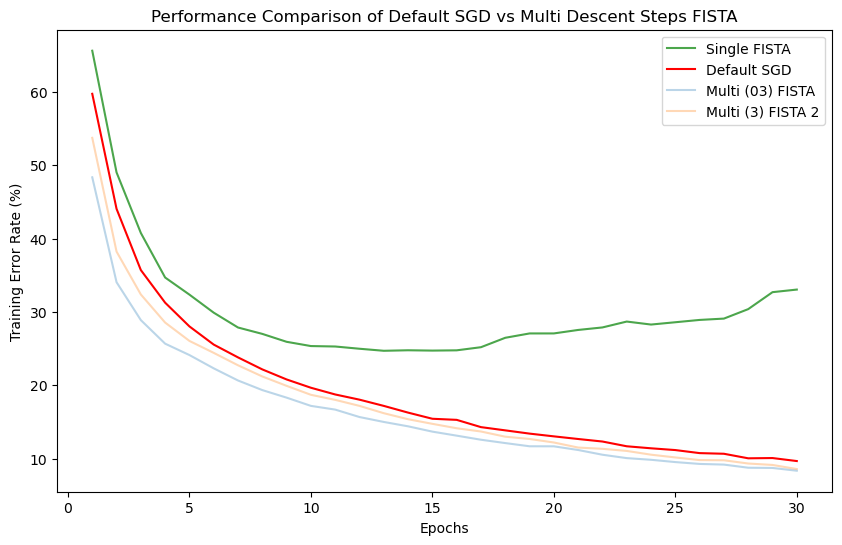

In [9]:
import json
import matplotlib.pyplot as plt

sngl_sgd = "/home/tung5534/cnn_cifar/W08/optimal_step_size/scores/E30T95/SGD_lr_0133_sngl.json"
mult_02_fista = "/home/tung5534/cnn_cifar/W08/fista_multi/scores/E30_ministeps_lr055/FISTA_5steps_lr_2.json"
mult_03_fista = "/home/tung5534/cnn_cifar/W08/fista_multi/scores/E30_ministeps_lr055/FISTA_5steps_lr_3.json"
mult_05_fista = "/home/tung5534/cnn_cifar/W08/fista_multi/scores/E30_ministeps_lr055/FISTA_5steps_lr_5.json"
mult_08_fista = "/home/tung5534/cnn_cifar/W08/fista_multi/scores/E30_ministeps_lr055/FISTA_5steps_lr_8.json"
mult_10_fista = "/home/tung5534/cnn_cifar/W08/fista_multi/scores/E30_ministeps_lr055/FISTA_5steps_lr_10.json"

mult_03_fista_v2 = '/home/tung5534/cnn_cifar/W08/fista_multi/scores/E30_3STEPS_lr055/FISTA_5steps_lr_3.json'

sngl_fista = "/home/tung5534/cnn_cifar/W08/fista_single/scores/FISTA_sngl_lr_0.0007.json"

sngl_scores = json.load(open(sngl_sgd, 'r'))
mult_02_scores = json.load(open(mult_02_fista, 'r'))
mult_03_scores = json.load(open(mult_03_fista, 'r'))
mult_05_scores = json.load(open(mult_05_fista, 'r'))
mult_08_scores = json.load(open(mult_08_fista, 'r'))
mult_10_scores = json.load(open(mult_10_fista, 'r'))

sngl_fista_scores = json.load(open(sngl_fista, 'r'))

mult_03_fista2_scores = json.load(open(mult_03_fista_v2, 'r'))


print(sngl_scores.keys())
plt.figure(figsize=(10,6))
plt.plot(range(1, len(sngl_fista_scores['train_errs'][:30])+1), sngl_fista_scores['train_errs'][:30], linestyle='-', label='Single FISTA', color='green', alpha=.7)
plt.plot(range(1, len(sngl_scores['train_errs'][:30])+1), sngl_scores['train_errs'][:30], linestyle='-', label='Default SGD', color='red')
# plt.plot(range(1, len(mult_02_scores['train_errs'])+1), mult_02_scores['train_errs'], linestyle='-', label='Multi (02) FISTA', alpha=.3)
plt.plot(range(1, len(mult_03_scores['train_errs'])+1), mult_03_scores['train_errs'], linestyle='-', label='Multi (03) FISTA', alpha=.3)
# plt.plot(range(1, len(mult_05_scores['train_errs'])+1), mult_05_scores['train_errs'], linestyle='-', label='Multi (05) FISTA', alpha=.3)
# plt.plot(range(1, len(mult_08_scores['train_errs'])+1), mult_08_scores['train_errs'], linestyle='-', label='Multi (08) FISTA', alpha=.3)
# plt.plot(range(1, len(mult_10_scores['train_errs'])+1), mult_10_scores['train_errs'], linestyle='-', label='Multi (10) FISTA', alpha=.3)

plt.plot(range(1, len(mult_03_fista2_scores['train_errs'])+1), mult_03_fista2_scores['train_errs'], linestyle='-', label='Multi (3) FISTA 2', alpha=.3)

plt.xlabel('Epochs')
plt.ylabel('Training Error Rate (%)')
plt.title('Performance Comparison of Default SGD vs Multi Descent Steps FISTA')
plt.legend()
plt.show()

**Optimal Step size for FISTA 5steps is 0.055**